In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

In [2]:
# Analitical freshwater Froude number Ff and mixing parameter P
Ff0 = np.linspace(1e-3, 1e0, 1000)
P0 = 0.5 / (Ff0 ** (2/3))

# Model results
Hs = 10 # sill depth
cp = (1 - Hs/150) * 100 # constriction percentage
xloc = 28 # constriction point
B = 9 * 200 # fjord width
Qf = np.linspace(100, 1000, 10) # freshwater discharge
beta = 8e-4 # saline contraction coefficient psu-1
g = 9.8

In [3]:
def hydro_control(filename, Qf, Hs, xloc):
    state0 = xr.open_dataset(filename) 
    t0 = 60 # Start from day 30
    tn = len(state0.T) # End day
    state = state0.isel(Y = range(1,10), T = range(t0,tn)) # Remove the boundary walls in y direction
    s = state.S.data.mean(2).mean(0)
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
    u = u_ymean.mean(0)
    # Layer interface, zero velocity crossing point
    u_sill = u[:, xloc]
    l = np.where(u_sill > 0)[-1][-1] + 1
    # Layer index of the sill depth
    ls = np.argwhere(u_sill == 0)[0][0]
    s1 = s[:l, xloc].mean(0)
    s2 = s[l:ls, xloc].mean(0)
    P = s2 / (s2 - s1)   # Mixing parameter
    Ff = Qf / np.sqrt(beta * g * s2 * (B**2) * (Hs**3))
    return (Ff, P)

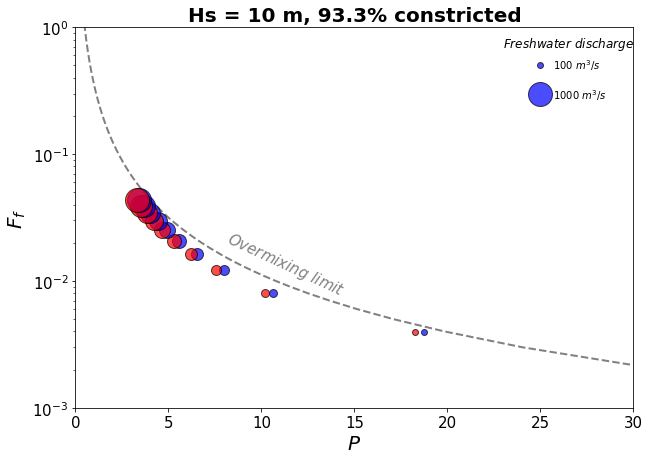

In [4]:
fig_path = "/Users/weiyangbao/Documents/Model_outputs/HydraulicMap/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
fig, ax =plt.subplots(figsize=(10,7))
ax.set_xlim([0,30])
ax.set_ylim([1e-3,1])
ax.set_yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$P$', size=20, weight='bold')
plt.ylabel(r'$F_f$', size=20, weight='bold')
plt.plot(P0, Ff0, color='gray', linestyle='--', linewidth=2)
ax.text(8,2e-2,r'$Overmixing$ $limit$', rotation=-25, size=15, color='gray')
plt.title('Hs = ' + str(Hs) + ' m, ' 
          + format(cp, '.1f') + '% constricted', size = 20, weight = 'bold')


x_mark = [25, 25]
y_mark = [3e-1, 5e-1]
plt.plot(x_mark[0],y_mark[0], marker='o', alpha=.7, ms=2*(9+3), color='b', markeredgecolor='k')
plt.plot(x_mark[1],y_mark[1], marker='o', alpha=.7, ms=2*(0+3), color='b', markeredgecolor='k')
plt.text(x_mark[0]+0.7, y_mark[0]-3e-2, '1000 $m^3/s$', fontsize=10)
plt.text(x_mark[1]+0.7, y_mark[1]-3e-2, '100 $m^3/s$', fontsize=10)
ax.text(23,7e-1,r'$Freshwater$ $discharge$', size=12)

import glob
files1 = sorted(glob.glob('/Users/weiyangbao/Documents/Model_outputs/nodrag_010/state_*.nc'))
files2 = sorted(glob.glob('/Users/weiyangbao/Documents/Model_outputs/drag_010/state_*.nc'))
for i in range(len(files1)): 
    Ff1, P1 = hydro_control(files1[i], Qf[i], Hs, xloc)
    Ff2, P2 = hydro_control(files2[i], Qf[i], Hs, xloc)
    plt.plot([P1],[Ff1], marker='o', alpha=.7, ms=2*(i+3), color='b', markeredgecolor='k')
    plt.plot([P2],[Ff2], marker='o', alpha=.7, ms=2*(i+3), color='r', markeredgecolor='k')

fig.savefig(fig_path + '/HC10.png', dpi = 150, bbox_inches='tight')

# Find the point where the salinity is the average of the highest and lowest values
import numpy.ma as ma
s = state.S.data.mean(2).mean(0)
s_sill = s[:,xloc]
ls = np.argwhere(s_sill == 0)[0][0]
s_ma = ma.masked_values (s_sill, 0.)
s_mean = (max(s_ma) + min(s_ma)) / 2
idx = (np.abs(s_sill - s_mean)).argmin()